In [8]:
import zipfile
import cv2
import numpy as np
from matplotlib import pyplot

from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"
print("\n\nShow Devices:\n\n"+str(device_lib.list_local_devices()))
cv2.__version__

Show System RAM Memory:


MemTotal:        8074324 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11260769588855000508
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3382837248
locality {
  bus_id: 1
  links {
  }
}
incarnation: 450272965424370591
physical_device_desc: "device: 0, name: GeForce GT 640, pci bus id: 0000:01:00.0, compute capability: 3.0"
]


'4.1.1'

In [9]:
from numpy import asarray

def plot_images(images, n):
    for i in range(n * n):
        if(i >= len(images)):
            break
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data # change from opencv-bgr to matplot-rgb
        pyplot.imshow(images[i][...,::-1].astype('uint8'))
    pyplot.show()

# load all images in a directory into memory
def load_images(start_point, number_limit, archive_name, size=(256,256)):
    # print(dirlist)
    src_list = list()
    archive = zipfile.ZipFile(archive_name, 'r')
    dirlist = archive.namelist()[1:]
    with archive as zfile:

        # enumerate filenames in directory, assume all are images
        for index in range(start_point, start_point + number_limit):
            # load and resize the image

            data = zfile.read(dirlist[index])
            imgfile = cv2.imdecode(np.frombuffer(data, np.uint8), 1)

            resize = cv2.resize(imgfile, size)

            # cv2.imshow("0", resize)
            # cv2.waitKey(10)
            # pixels = img_to_array(resize)
            # print(resize.shape)
            # print(index)
            src_list.append(resize)

    return asarray(src_list)

In [10]:
# example of pix2pix gan for satellite to map image-to-image translation
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_src_image = Input(shape=image_shape)
    # target image input
    in_target_image = Input(shape=image_shape)
    # concatenate images channel-wise
    merged = Concatenate()([in_src_image, in_target_image])
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(d)
    # define model
    model = Model([in_src_image, in_target_image], patch_out)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # connect the source image to the generator input
    gen_out = g_model(in_src)
    # connect the source input and generator output to the discriminator input
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and classification output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

# load and prepare training images
def prepare_real_samples(file):
    # load compressed arrays
    # data = load(filename)
    # load the face dataset
    # color_images = data['arr_0'].astype('uint8')
    color_images = file
    
    # print(type(src_images))
    gray_images = color_images.astype('uint8')
    gray_images [:,:,:,0] = color_images[:,:,:,0]/3 + color_images[:,:,:,1]/3 + color_images[:,:,:,2]/3
    gray_images [:,:,:,1] = gray_images [:,:,:,0]
    gray_images [:,:,:,2] = gray_images [:,:,:,0]
    
    # unpack arrays
    X1 = gray_images
    X2 = color_images

#     plot_images(color_images, 10)
#     plot_images(gray_images, 10)
    
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

# generate samples and save as a plot and save the model
def summarize_performance(save_path, step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i][...,::-1])
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i][...,::-1])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i][...,::-1])
    # save plot to file
    filename1 = save_path + 'plot_%03d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    # filename2 = 'model_%06d.h5' % (step+1)
    # g_model.save(filename2)
    # print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        
        if i%10==0:
            summary = sess.run(merged,feed_dict={D_LOSS:d_loss2, G_LOSS:g_loss})
            writer.add_summary(summary,i)
            
#         # summarize model performance
#         if (i+1) % (bat_per_epo * 10) == 0:
#             summarize_performance(i, g_model, dataset)

In [11]:
# Tensorboard
import tensorflow as tf
import datetime

# tf.reset_default_graph() # don't know what is this, but it fixed bugs

tensorboard_dir = "/home/isaiah/GAN_practice_no_git/logs/"

# start tensorboard
sess = tf.Session()
logdir = tensorboard_dir + datetime.datetime.now().strftime("GAN_GRAY2BGR-%Y%m%d-%H%M")
writer = tf.summary.FileWriter(logdir, sess.graph)

D_LOSS = tf.placeholder(tf.float32, [])
G_LOSS = tf.placeholder(tf.float32, [])

tf.summary.scalar("D_LOSS", D_LOSS)
tf.summary.scalar("G_LOSS", G_LOSS)

merged=tf.summary.merge_all()
# end tensorboard

82783
load_steps 1
load_leftover 3
Loaded (10, 256, 256, 3) (10, 256, 256, 3)


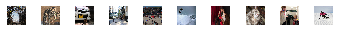

Loaded (3, 256, 256, 3) (3, 256, 256, 3)


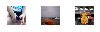

In [12]:
data_path = "/home/isaiah/Downloads/train2014.zip"
model_save_path = "/home/isaiah/GAN_practice_no_git/models/"
summery_path = "/home/isaiah/GAN_practice_no_git/performances/"

archive = zipfile.ZipFile(data_path, 'r')
dirlist = archive.namelist()[1:]

full_size = len(dirlist)
full_size = 10000
part_size = 100

print(full_size)

load_steps = int(full_size/part_size)
# load_steps = 1
load_leftover = full_size%part_size


print("load_steps", load_steps)
print("load_leftover", load_leftover)

#### define everything ####

# define input shape
# image_shape = (dataset[0].shape[1:])
image_shape = (256, 256, 3)

# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)


#### train part!! ####
for step in range(0, load_steps + 1):
    start_point = step * part_size

    if (step < load_steps):
        number_limit = part_size
    else:
        number_limit = load_leftover

    src_images = load_images(start_point, number_limit, data_path)
    dataset = prepare_real_samples(src_images)
    print('Loaded', dataset[0].shape, dataset[1].shape)

    #### train here!! ####

    plot_images(src_images, 10)
    # plot_images(dataset[1], 10)
#     train(d_model, g_model, gan_model, dataset)
    
    time_now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    g_model_name = model_save_path + 'step_%03d_' % (step+1) + "G_GRAY2RGB-" + time_now + ".h5"
    d_model_name = model_save_path + 'step_%03d_' % (step+1) + "D_GRAY2RGB-" + time_now + ".h5"
    gan_model_name = model_save_path + 'step_%03d_' % (step+1) + "GAN_GRAY2RGB-" + time_now + ".h5"
    
#     summarize_performance(summery_path, step, g_model, dataset)
#     print(g_model_name)
#     print(d_model_name)
#     print(gan_model_name)
        
    # save the modelS
    
    g_model.save(g_model_name)
    d_model.save(d_model_name)
    gan_model.save(gan_model_name)
    
    summarize_performance(summery_path, step, g_model, dataset)
    del src_images
    del dataset